神戸市の[年齢別の人口データ](http://www.city.kobe.lg.jp/information/data/statistics/toukei/jinkou/juukijinkou.html)（オープンデータ）をNMFで成分分析しましたが、Jupyter notebook で手順を確認できるようにしてみます。

目標は「年齢別の人口の地域差を眺める」です。

In [1]:
import functools
import pandas as pd
import geopandas as gpd
import sklearn.decomposition
from shapely.geometry import Point
from matplotlib import pyplot as plt

In [2]:
# この部分は環境依存なので適宜調整してください
%matplotlib inline
import matplotlib
jafont=matplotlib.font_manager.FontProperties(fname="ipaexg.ttf")
ja = dict(fontproperties=jafont)

Excel では区・支所ごとに複数のシートに分割されているので、まとめて読み込んで結合します。

In [3]:
def load_zensi(fname):
    e = pd.ExcelFile(fname)
    opts = dict(skiprows=1, converters={"区コード":str, "町コード":str})
    dfs = [e.parse(s, **opts).iloc[1:,:] for s in e.sheet_names if s != "神戸市"]
    return gpd.GeoDataFrame(pd.concat(dfs, ignore_index=True))

一番新しいデータで分析してみます。

In [4]:
data0 = load_zensi("../data/kobe/zensi2808.xls")

日本語のインデックスを毎回タイプするのは大変なので、次のように保持しておきます。

In [5]:
ages=["%d歳" % i for i in range(100)]+["100歳以上"]

## 年齢別の人口

神戸市全体で概形を見てみます。

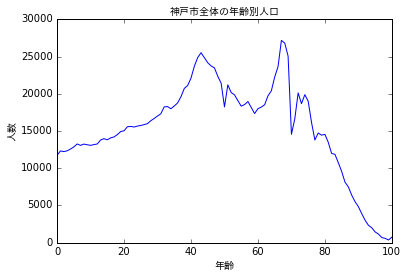

In [6]:
plt.plot(data0[ages].sum().values)
plt.title("神戸市全体の年齢別人口", **ja)
plt.xlabel("年齢", **ja)
plt.ylabel("人数", **ja)

統計の集計単位の、区・支所ごとで分類して見てみます。

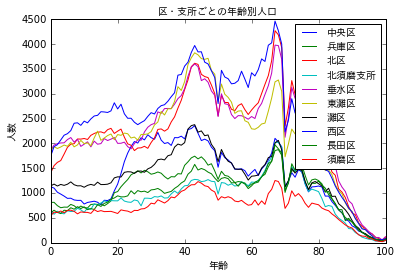

In [7]:
data0g = data0.groupby("区・支所")[ages].sum()
plt.plot(data0g.T.values)
plt.title("区・支所ごとの年齢別人口", **ja)
plt.xlabel("年齢", **ja)
plt.ylabel("人数", **ja)
plt.legend(data0g.index, prop=jafont)

こうして見てみると、同じような成分が共通してみられます。一方で、例えば中央区と西区では子供の20歳以下の分布の形は大きく違います。年齢別の分布には実際に地域差がありそうです。

## 成分分析

NMF という手法で成分を分離してみます。ここでは 3 成分に分解します。

In [8]:
# Null 値を自動で読み飛ばす機能はないので、あらかじめ除去しておく
data1 = data0[data0[ages].isnull().any(axis=1)==False]
m = sklearn.decomposition.NMF(3)
o = m.fit_transform(data1[ages])

NMFでは成分が順不同で得られます。高年齢成分を赤、低年齢成分を緑に固定するために色を別途割り当てます。

In [9]:
qv = pd.DataFrame(m.components_.dot([i*2 for i in range(101)]), columns=["sort_key"]).sort_values("sort_key", ascending=False)
cc = ["rbg"[list(qv.index).index(i)] for i in range(m.n_components)]

3成分に分解した各成分（年齢分布）をプロットしてみます。

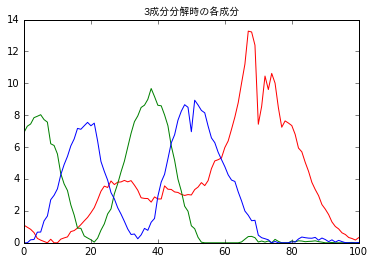

In [10]:
for i,r in enumerate(m.components_):
    plt.plot(r, color=cc[i])

plt.title("3成分分解時の各成分", **ja)

集計地区単位ごとに、どのような重みづけで分布しているかをプロットしてみます。

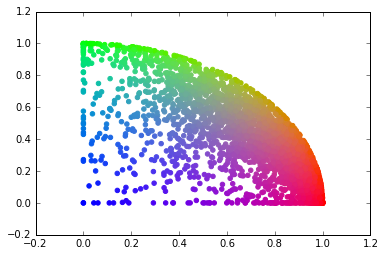

In [11]:
o2=sklearn.preprocessing.normalize(o)
o3=pd.DataFrame(o2, columns=cc)
c = o3.apply(lambda r:"#%02x%02x%02x" % tuple([int(r.get(k, 0)*255) for k in "rgb"]), axis=1)
plt.scatter(o2[:,0], o2[:,1], color=c)

## 地図上にプロット

地図上にこの集団をプロットしてみます。町名から緯度経度（代表点）を求めます。

In [12]:
qname = data0.apply(lambda r:"神戸市 %s %s" % (r["区・支所"].replace("支所",""), r["町名"]), axis=1)
try:
    cache = pd.read_json(open("../cache/kobe.json", encoding="UTF-8")).T
except:
    cache = pd.DataFrame([], columns=["lat", "lng"])

loc = pd.DataFrame(qname, columns=["qname"]).join(cache, on="qname")

In [13]:
## To rebuild cache/kobe.json, save qname
# loc[loc[["lat","lng"]].isnull().any(axis=1)]["qname"]

In [14]:
geo = gpd.GeoDataFrame(pd.concat([data0, loc], axis=1))
data1 = geo[geo[["lat","lng"]].isnull().any(axis=1)==False]
pt = pd.DataFrame(data1.apply(lambda r:Point(r["lng"], r["lat"]), axis=1), columns=["geometry"])
data2 = gpd.GeoDataFrame(pd.concat([data1, pt], axis=1), crs="+init=epsg:4326")

e-Stat の区域データを使って区の外形線を取り出します。

In [15]:
pib_fs = ["../data/estat/h22ka281%02d.shp" % i for i in [1,2,5,6,7,8,9,10,11]]
us = [gpd.read_file(f) for f in pib_fs]
crs = us[0].crs
pib = gpd.GeoDataFrame(pd.concat(us, ignore_index=True), crs=crs)
pib2 = pib[(pib["MOJI"]!="水面") & (pib["MOJI"].isnull()==False)] # 海上を取り除く
css = list(set(pib2["CSS_NAME"])) # 区の名前一覧

pib3 = gpd.GeoDataFrame([{"geometry":functools.reduce(lambda x,y:x.union(y), pib2[pib2["CSS_NAME"]==a].geometry), "CSS_NAME":a} for a in css])

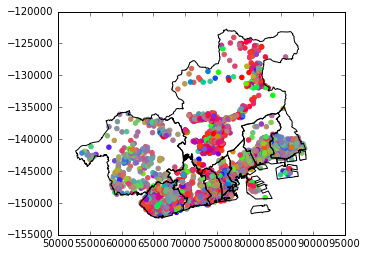

In [16]:
pib3.plot(alpha=0)
pt2 = data2.to_crs(crs)
plt.scatter(pt2.geometry.bounds.minx, pt2.geometry.bounds.miny, color=c, alpha=1.0)

地図を見る専用のアプリケーションのほうが状況がよく見えそうです。